In [2]:
# Data preprocessing
#from google.colab import drive # 從google drive load data
#drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.datasets import ImageFolder


batch_size = 16 # 取1328和288的最大公因數
#train_path = 'drive/MyDrive/stanford_dogs_dataset/train/' # 1328個
#test_path = 'drive/MyDrive/stanford_dogs_dataset/test/' # 288個
train_path = 'stanford_dogs_dataset/train/'
test_path = 'stanford_dogs_dataset/test/'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_data = torchvision.datasets.ImageFolder(root=train_path, transform=transform) # 用ImageFolder因為dataset是用folder分類
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,  num_workers=2)
test_data = torchvision.datasets.ImageFolder(root=test_path, transform=transform)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False,  num_workers=2)

In [ ]:
# 1 CNN Model
import torch.nn.functional as F
from torch import nn
from torchsummary import summary
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

dropout = 0.5
num_classes = 8
# Define model
class HungNet(nn.Module):   # 這裡參考了2012年的AlexNet架構
    def __init__(self):
        super(HungNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
        

model = HungNet().to(device)
summary(model.cuda(), (3, 224, 224)) # 看看總參數量以及各層組成

Using cuda device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14 

In [ ]:
# 1 training
criterion = nn.CrossEntropyLoss() # loss計算方法
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # 使用Adam下降法更新參數，選Adam是因為學習較快
train_loss_list=[] 
test_loss_list=[]
train_acc_list=[]
test_acc_list=[]
epochs=80 # 這裡eopchs設多因為batch_size小和learing rate也小，acc上升較慢要跑多次epochs
for epoch in range(epochs):  # loop over the dataset multiple times

    training_loss = 0.0
    testing_loss = 0.0
    train_correct = 0.0
    test_correct = 0.0
    train_total = 0.0
    test_total = 0.0
    model.train() # 設定model目前階段
    for data, target in (train_data_loader):  # training
        # get the inputs; data is a list of [inputs, labels]
        data, target = data.cuda(), target.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        # print statistics
        training_loss += loss.item()
        pred = outputs.data.max(dim = 1, keepdim = True)[1]
        train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        train_total += data.size(0)




    model.eval() # 設定model目前階段
    for data, target in (test_data_loader):    
        # get the inputs; data is a list of [inputs, labels]
        data, target = data.cuda(), target.cuda()
        # forward + backward + optimize
        outputs = model(data)
        loss = criterion(outputs, target)
        # print statistics
        testing_loss += loss.item()
        pred = outputs.data.max(dim = 1, keepdim = True)[1]
        test_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        test_total += data.size(0)

    avg_loss = training_loss/(1328/batch_size)
    avg_acc = train_correct/train_total
    train_loss_list.append(avg_loss)
    train_acc_list.append(avg_acc)
    print('\n'+'Epoch: {}, Train. Acc: {}, Train. Loss: {}'.format(epoch + 1, avg_acc, avg_loss))
    avg_loss = testing_loss/(288/batch_size)
    avg_acc = test_correct/test_total
    test_loss_list.append(avg_loss)
    test_acc_list.append(avg_acc)
    print('Epoch: {}, Test. Acc: {}, Test. Loss: {}'.format(epoch + 1, avg_acc, avg_loss))
print('Finished Training')


Epoch: 1, Train. Acc: 0.11219879518072289, Train. Loss: 2.0831078563828065
Epoch: 1, Test. Acc: 0.125, Test. Loss: 2.0790972974565296

Epoch: 2, Train. Acc: 0.10617469879518072, Train. Loss: 2.079377875270614
Epoch: 2, Test. Acc: 0.11805555555555555, Test. Loss: 2.0649406645033093

Epoch: 3, Train. Acc: 0.17545180722891565, Train. Loss: 2.033237813467003
Epoch: 3, Test. Acc: 0.1909722222222222, Test. Loss: 2.0192596117655435

Epoch: 4, Train. Acc: 0.18900602409638553, Train. Loss: 1.9759282835994858
Epoch: 4, Test. Acc: 0.20833333333333334, Test. Loss: 1.9553683863745794

Epoch: 5, Train. Acc: 0.2161144578313253, Train. Loss: 1.966089938060347
Epoch: 5, Test. Acc: 0.16666666666666666, Test. Loss: 1.9761348697874281

Epoch: 6, Train. Acc: 0.2575301204819277, Train. Loss: 1.9230919631130725
Epoch: 6, Test. Acc: 0.2326388888888889, Test. Loss: 1.9615550372335646

Epoch: 7, Train. Acc: 0.276355421686747, Train. Loss: 1.872016070836998
Epoch: 7, Test. Acc: 0.23958333333333334, Test. Loss: 

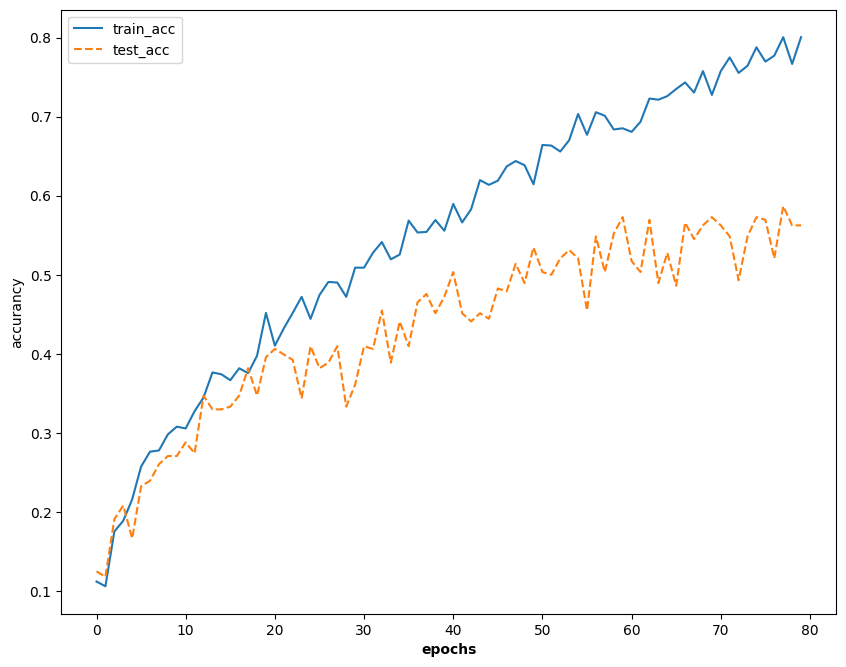

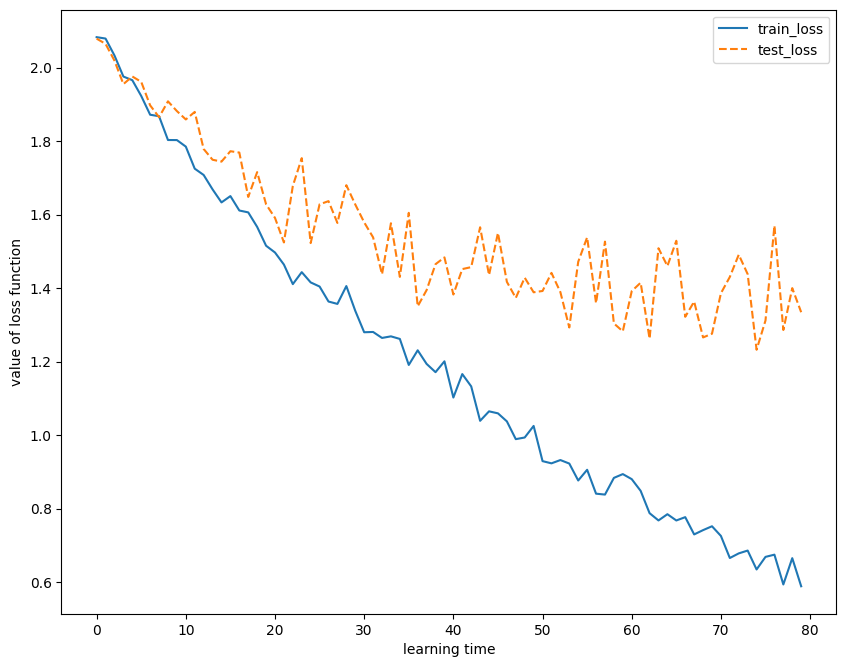

In [ ]:
# 1 plot
x=range(len(train_acc_list))
y1=train_acc_list
y2=test_acc_list
plt.figure(figsize=(10,8), dpi=100)
plt.plot(x,y1,label='train_acc')
plt.plot(x,y2,linestyle='--',label='test_acc')
plt.xlabel('epochs', fontweight="bold")
plt.ylabel('accurancy')
plt.legend()
plt.show()
 

# plt loss
x=range(epochs)
y1=train_loss_list
y2=test_loss_list
plt.figure(figsize=(10,8), dpi=100)
plt.plot(x,y1,label='train_loss')
plt.plot(x,y2,linestyle='--',label='test_loss')
plt.xlabel('learning time')
plt.ylabel('value of loss function')
plt.legend()
plt.show()

In [3]:
# 2 Data preprocessing
# 這邊用不同Data process因為想改變batch_size大小，與第一題不一樣
#from google.colab import drive # 從google drive load data
#drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.datasets import ImageFolder


batch_size = 16 # 取1328和288的最大公因數
#train_path = 'drive/MyDrive/stanford_dogs_dataset/train/' # 1328個
#test_path = 'drive/MyDrive/stanford_dogs_dataset/test/' # 288個
train_path = 'stanford_dogs_dataset/train/'
test_path = 'stanford_dogs_dataset/test/'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_data = torchvision.datasets.ImageFolder(root=train_path, transform=transform) # 用ImageFolder因為dataset是用folder分類
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,  num_workers=2)
test_data = torchvision.datasets.ImageFolder(root=test_path, transform=transform)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False,  num_workers=2)

In [6]:
# 2(a) ResNet-18
import torch.nn.functional as F
from torch import nn
from torchsummary import summary
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

num_classes = 8
# Define model
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1, downsample=None):# inplanes = block inputs channel num
        super(BasicBlock, self).__init__() # planes = block ouput channel
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

        
class ResNet(nn.Module):

  def __init__(self, block, num_classes=8, zero_init_residual=False):
    super(ResNet, self).__init__()
    self.inplanes = 64 
    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                 bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.layer1 = self._make_layer(block, 64, 2, stride=1)
    self.layer2 = self._make_layer(block, 128, 2, stride=2)
    self.layer3 = self._make_layer(block, 256, 2, stride=2)
    self.layer4 = self._make_layer(block, 512, 2, stride=2)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512, num_classes)


  def _make_layer(self, block, planes, blocks, stride=1):
      downsample = None
      if stride != 1 or self.inplanes != planes: # 注意維度
        downsample = nn.Sequential(
          nn.Conv2d(self.inplanes, planes, stride),nn.BatchNorm2d(planes),)
      layers = []
      layers.append(block(self.inplanes, planes, stride, downsample))
      self.inplanes = planes
      for _ in range(1, blocks):
        layers.append(block(self.inplanes, planes))

      return nn.Sequential(*layers)
  
  def forward(self, x):
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.maxpool(x)

      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)

      x = self.avgpool(x)
      x = x.view(x.size(0), -1)
      x = self.fc(x)

      return x
def ResNet18():
  return ResNet(BasicBlock)
model = ResNet18().to(device)
summary(model.cuda(), (3, 224, 224))

Using cuda device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
        BasicBlock-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
       BasicBlock-14 

In [7]:
# 2(a) training
criterion = nn.CrossEntropyLoss() # loss計算方法
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # 使用Adam下降法更新參數，選Adam是因為學習較快
train_loss_list=[] 
test_loss_list=[]
train_acc_list=[]
test_acc_list=[]
epochs=50
for epoch in range(epochs):  # loop over the dataset multiple times

    training_loss = 0.0
    testing_loss = 0.0
    train_correct = 0.0
    test_correct = 0.0
    train_total = 0.0
    test_total = 0.0
    model.train() # 設定model目前階段
    for data, target in (train_data_loader):  # training
        # get the inputs; data is a list of [inputs, labels]
        data, target = data.cuda(), target.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        # print statistics
        training_loss += loss.item()
        pred = outputs.data.max(dim = 1, keepdim = True)[1]
        train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        train_total += data.size(0)




    model.eval() # 設定model目前階段
    for data, target in (test_data_loader):    
        # get the inputs; data is a list of [inputs, labels]
        data, target = data.cuda(), target.cuda()
        # forward + backward + optimize
        outputs = model(data)
        loss = criterion(outputs, target)
        # print statistics
        testing_loss += loss.item()
        pred = outputs.data.max(dim = 1, keepdim = True)[1]
        test_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        test_total += data.size(0)

    avg_loss = training_loss/(1328/batch_size)
    avg_acc = train_correct/train_total
    train_loss_list.append(avg_loss)
    train_acc_list.append(avg_acc)
    print('\n'+'Epoch: {}, Train. Acc: {}, Train. Loss: {}'.format(epoch + 1, avg_acc, avg_loss))
    avg_loss = testing_loss/(288/batch_size)
    avg_acc = test_correct/test_total
    test_loss_list.append(avg_loss)
    test_acc_list.append(avg_acc)
    print('Epoch: {}, Test. Acc: {}, Test. Loss: {}'.format(epoch + 1, avg_acc, avg_loss))
print('Finished Training')


Epoch: 1, Train. Acc: 0.25150602409638556, Train. Loss: 2.0280539903296044
Epoch: 1, Test. Acc: 0.13541666666666666, Test. Loss: 2.854963355594211

Epoch: 2, Train. Acc: 0.3245481927710843, Train. Loss: 1.8587108060538051
Epoch: 2, Test. Acc: 0.2638888888888889, Test. Loss: 2.391066789627075

Epoch: 3, Train. Acc: 0.3742469879518072, Train. Loss: 1.7339488454611904
Epoch: 3, Test. Acc: 0.3159722222222222, Test. Loss: 2.2058576742808023

Epoch: 4, Train. Acc: 0.4006024096385542, Train. Loss: 1.6841744974435093
Epoch: 4, Test. Acc: 0.34375, Test. Loss: 2.1786102188958063

Epoch: 5, Train. Acc: 0.4307228915662651, Train. Loss: 1.5865915367402226
Epoch: 5, Test. Acc: 0.3541666666666667, Test. Loss: 1.9866669707828097

Epoch: 6, Train. Acc: 0.463855421686747, Train. Loss: 1.5221732438328754
Epoch: 6, Test. Acc: 0.3888888888888889, Test. Loss: 1.9162592887878418

Epoch: 7, Train. Acc: 0.4796686746987952, Train. Loss: 1.479909954300846
Epoch: 7, Test. Acc: 0.3715277777777778, Test. Loss: 1.8

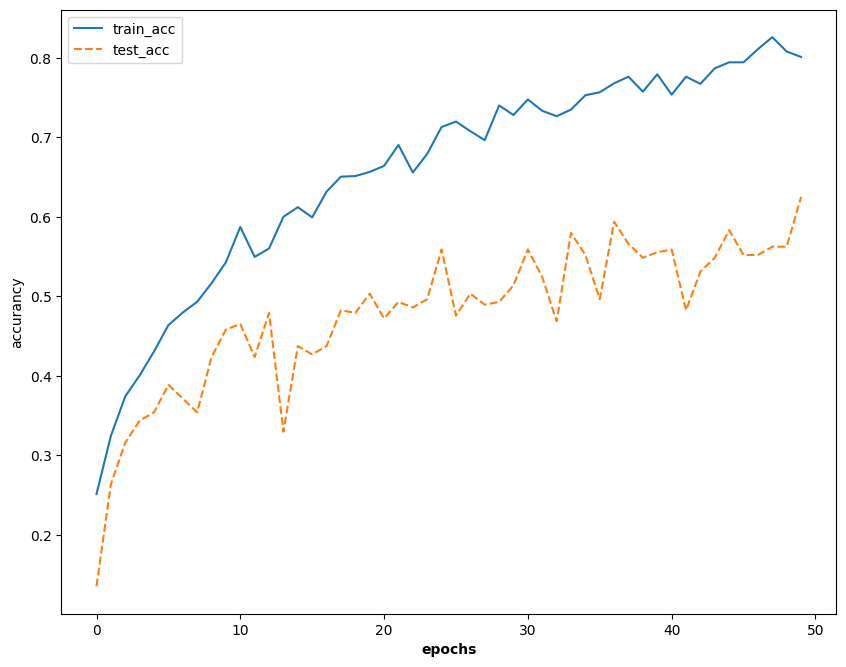

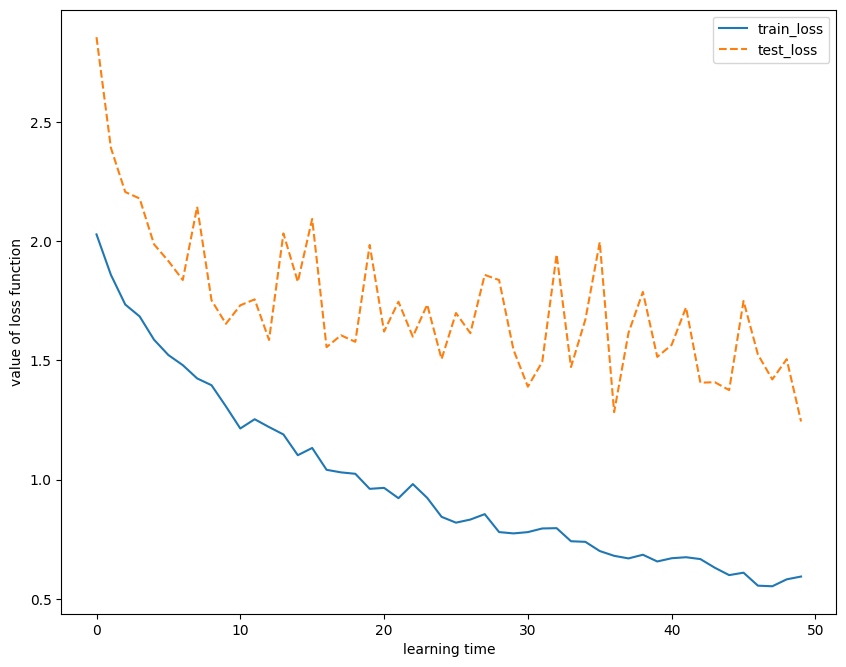

In [8]:
# 2(a) plot
x=range(len(train_acc_list))
y1=train_acc_list
y2=test_acc_list
plt.figure(figsize=(10,8), dpi=100)
plt.plot(x,y1,label='train_acc')
plt.plot(x,y2,linestyle='--',label='test_acc')
plt.xlabel('epochs', fontweight="bold")
plt.ylabel('accurancy')
plt.legend()
plt.show()
 

# plt loss
x=range(epochs)
y1=train_loss_list
y2=test_loss_list
plt.figure(figsize=(10,8), dpi=100)
plt.plot(x,y1,label='train_loss')
plt.plot(x,y2,linestyle='--',label='test_loss')
plt.xlabel('learning time')
plt.ylabel('value of loss function')
plt.legend()
plt.show()

In [4]:
# 2(b) ResNet18 remove identity mapping
import torch.nn.functional as F
from torch import nn
from torchsummary import summary
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

num_classes = 8
# Define model
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1, downsample=None):# inplanes = block inputs channel num
        super(BasicBlock, self).__init__() # planes = block ouput channel
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
# 與前一次ResNet架構大致相同，差在沒有shortcut
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = F.relu(out)
        return out

        
class ResNet(nn.Module):

  def __init__(self, block, num_classes=8, zero_init_residual=False):
    super(ResNet, self).__init__()
    self.inplanes = 64 
    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                 bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.layer1 = self._make_layer(block, 64, 2, stride=1)
    self.layer2 = self._make_layer(block, 128, 2, stride=2)
    self.layer3 = self._make_layer(block, 256, 2, stride=2)
    self.layer4 = self._make_layer(block, 512, 2, stride=2)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512, num_classes)


  def _make_layer(self, block, planes, blocks, stride=1):
      downsample = None
      if stride != 1 or self.inplanes != planes: # 注意維度
        downsample = nn.Sequential(
          nn.Conv2d(self.inplanes, planes, stride),nn.BatchNorm2d(planes),)
      layers = []
      layers.append(block(self.inplanes, planes, stride, downsample))
      self.inplanes = planes
      for _ in range(1, blocks):
        layers.append(block(self.inplanes, planes))

      return nn.Sequential(*layers)
  
  def forward(self, x):
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.maxpool(x)

      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)

      x = self.avgpool(x)
      x = x.view(x.size(0), -1)
      x = self.fc(x)

      return x
def ResNet18():
  return ResNet(BasicBlock)
model = ResNet18().to(device)
summary(model.cuda(), (3, 224, 224))

Using cuda device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
        BasicBlock-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
       BasicBlock-14 

In [5]:
# 2(b) training
criterion = nn.CrossEntropyLoss() # loss計算方法
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # 使用Adam下降法更新參數，選Adam是因為學習較快
train_loss_list=[] 
test_loss_list=[]
train_acc_list=[]
test_acc_list=[]
epochs=50
for epoch in range(epochs):  # loop over the dataset multiple times

    training_loss = 0.0
    testing_loss = 0.0
    train_correct = 0.0
    test_correct = 0.0
    train_total = 0.0
    test_total = 0.0
    model.train() # 設定model目前階段
    for data, target in (train_data_loader):  # training
        # get the inputs; data is a list of [inputs, labels]
        data, target = data.cuda(), target.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        # print statistics
        training_loss += loss.item()
        pred = outputs.data.max(dim = 1, keepdim = True)[1]
        train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        train_total += data.size(0)




    model.eval() # 設定model目前階段
    for data, target in (test_data_loader):    
        # get the inputs; data is a list of [inputs, labels]
        data, target = data.cuda(), target.cuda()
        # forward + backward + optimize
        outputs = model(data)
        loss = criterion(outputs, target)
        # print statistics
        testing_loss += loss.item()
        pred = outputs.data.max(dim = 1, keepdim = True)[1]
        test_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        test_total += data.size(0)

    avg_loss = training_loss/(1328/batch_size)
    avg_acc = train_correct/train_total
    train_loss_list.append(avg_loss)
    train_acc_list.append(avg_acc)
    print('\n'+'Epoch: {}, Train. Acc: {}, Train. Loss: {}'.format(epoch + 1, avg_acc, avg_loss))
    avg_loss = testing_loss/(288/batch_size)
    avg_acc = test_correct/test_total
    test_loss_list.append(avg_loss)
    test_acc_list.append(avg_acc)
    print('Epoch: {}, Test. Acc: {}, Test. Loss: {}'.format(epoch + 1, avg_acc, avg_loss))
print('Finished Training')


Epoch: 1, Train. Acc: 0.17243975903614459, Train. Loss: 2.1149779385830985
Epoch: 1, Test. Acc: 0.1701388888888889, Test. Loss: 2.1270518170462713

Epoch: 2, Train. Acc: 0.17996987951807228, Train. Loss: 2.0080673048295172
Epoch: 2, Test. Acc: 0.2013888888888889, Test. Loss: 2.000888420475854

Epoch: 3, Train. Acc: 0.2191265060240964, Train. Loss: 1.9765941105693219
Epoch: 3, Test. Acc: 0.24305555555555555, Test. Loss: 2.0997902552286782

Epoch: 4, Train. Acc: 0.21310240963855423, Train. Loss: 1.9756024989737087
Epoch: 4, Test. Acc: 0.22916666666666666, Test. Loss: 2.029079463746813

Epoch: 5, Train. Acc: 0.22364457831325302, Train. Loss: 1.966253638267517
Epoch: 5, Test. Acc: 0.2152777777777778, Test. Loss: 2.215666847096549

Epoch: 6, Train. Acc: 0.23042168674698796, Train. Loss: 1.938524649803897
Epoch: 6, Test. Acc: 0.1909722222222222, Test. Loss: 1.9813621905114915

Epoch: 7, Train. Acc: 0.21987951807228914, Train. Loss: 1.9771868564996375
Epoch: 7, Test. Acc: 0.22569444444444445

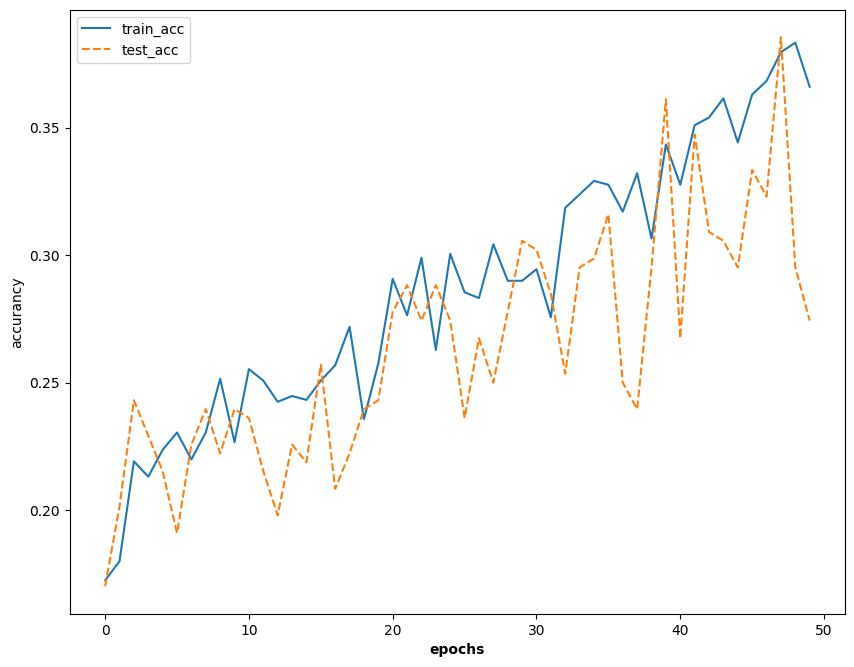

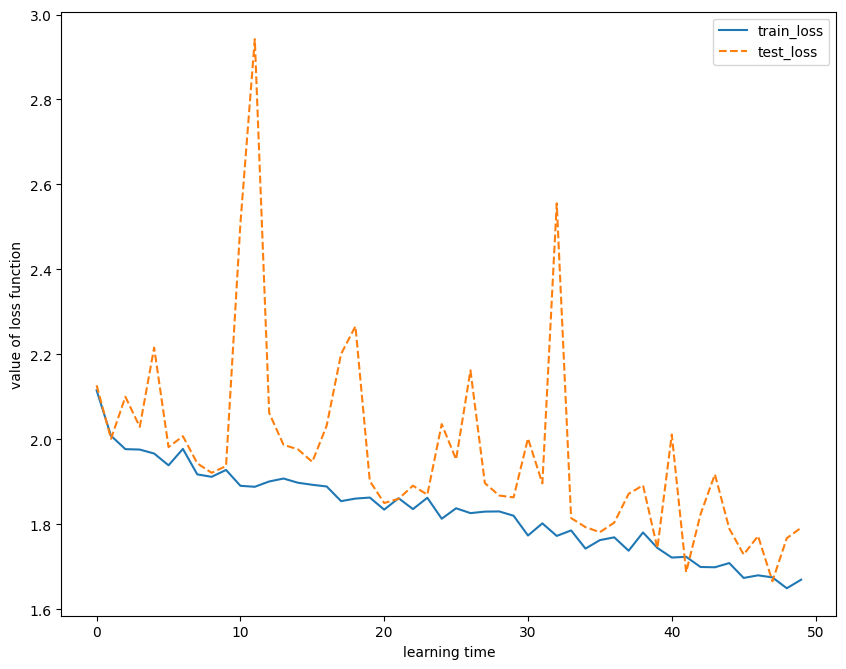

In [6]:
# 2(b) plot
x=range(len(train_acc_list))
y1=train_acc_list
y2=test_acc_list
plt.figure(figsize=(10,8), dpi=100)
plt.plot(x,y1,label='train_acc')
plt.plot(x,y2,linestyle='--',label='test_acc')
plt.xlabel('epochs', fontweight="bold")
plt.ylabel('accurancy')
plt.legend()
plt.show()
 

# plt loss
x=range(epochs)
y1=train_loss_list
y2=test_loss_list
plt.figure(figsize=(10,8), dpi=100)
plt.plot(x,y1,label='train_loss')
plt.plot(x,y2,linestyle='--',label='test_loss')
plt.xlabel('learning time')
plt.ylabel('value of loss function')
plt.legend()
plt.show()

# 2(b) discussion
很明顯能看出少了identity mapping的模型表現差很多。
因為ResNet有個shortcut是給identity走的，所以在算backpropagation時會有一個通路以相加方式連接，可以解決梯度消失的問題。若沒有identity mapping，就像是所有卷積層直接連接，對於過深網路會有退化問題(Degredation)。